# Week4 - Homework 2

- Execute the below code, then answer the numbered questions.
- You can create additinal code and markdown blocks

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


df = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/regression/car-reg-data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9055 entries, 0 to 9054
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   make           8164 non-null   object 
 1   transmission   8106 non-null   object 
 2   state          8152 non-null   object 
 3   condition      8173 non-null   float64
 4   odometer       8178 non-null   float64
 5   auction_value  8107 non-null   float64
 6   selling_price  9055 non-null   float64
dtypes: float64(4), object(3)
memory usage: 495.3+ KB


In [68]:
df.head(5)

,make,transmission,state,condition,odometer,auction_value,selling_price
0,nissan,automatic,md,4.8,NaN,14350.0,13600.0
1,ford,automatic,mo,3.7,29398.0,17600.0,17100.0
2,ford,automatic,fl,3.2,32180.0,19100.0,17600.0
3,nissan,automatic,ca,NaN,30798.0,11950.0,10700.0
4,ford,automatic,nj,2.8,29526.0,28000.0,26100.0


In [36]:
df.tail(5)

,make,transmission,state,condition,odometer,auction_value,selling_price
9050,NaN,automatic,il,4.2,41186.0,NaN,11600.0
9051,ford,automatic,fl,NaN,38810.0,16250.0,17300.0
9052,nissan,NaN,ga,4.7,4551.0,12500.0,13800.0
9053,ford,automatic,il,4.6,33114.0,21800.0,27000.0
9054,ford,automatic,ga,3.7,23776.0,28800.0,29800.0


In [37]:
df.describe()

,condition,odometer,auction_value,selling_price
count,8173.000000,8178.000000,8107.000000,9055.000000
mean,3.748232,41771.063341,15973.334772,15835.189398
std,0.817477,30163.811146,7775.612073,7910.008881
min,1.000000,1.000000,2350.000000,600.000000
25%,3.300000,21930.000000,11050.000000,10800.000000
50%,3.900000,35878.000000,13950.000000,13900.000000
75%,4.400000,54438.000000,18750.000000,18725.000000
max,5.000000,999999.000000,161000.000000,161000.000000


In [38]:
print(df.dtypes)

make              object
transmission      object
state             object
condition        float64
odometer         float64
auction_value    float64
selling_price    float64
dtype: object


In [39]:
df.memory_usage(deep=True)

,0
Index,132
make,539326
transmission,564881
state,509864
condition,72440
odometer,72440
auction_value,72440
selling_price,72440


In [40]:
for col in df.select_dtypes(include=['float64']).columns:
    df[col] = df[col].astype('float32')

In [41]:
df.memory_usage(deep=True)

,0
Index,132
make,539326
transmission,564881
state,509864
condition,36220
odometer,36220
auction_value,36220
selling_price,36220


## Question 1:
### Which features can we use?

In [48]:
df.isnull().sum()

,0
make,891
transmission,949
state,903
condition,882
odometer,877
auction_value,948
selling_price,0


array([[<Axes: xlabel='condition', ylabel='condition'>,
        <Axes: xlabel='odometer', ylabel='condition'>,
        <Axes: xlabel='auction_value', ylabel='condition'>,
        <Axes: xlabel='selling_price', ylabel='condition'>],
       [<Axes: xlabel='condition', ylabel='odometer'>,
        <Axes: xlabel='odometer', ylabel='odometer'>,
        <Axes: xlabel='auction_value', ylabel='odometer'>,
        <Axes: xlabel='selling_price', ylabel='odometer'>],
       [<Axes: xlabel='condition', ylabel='auction_value'>,
        <Axes: xlabel='odometer', ylabel='auction_value'>,
        <Axes: xlabel='auction_value', ylabel='auction_value'>,
        <Axes: xlabel='selling_price', ylabel='auction_value'>],
       [<Axes: xlabel='condition', ylabel='selling_price'>,
        <Axes: xlabel='odometer', ylabel='selling_price'>,
        <Axes: xlabel='auction_value', ylabel='selling_price'>,
        <Axes: xlabel='selling_price', ylabel='selling_price'>]],
      dtype=object)

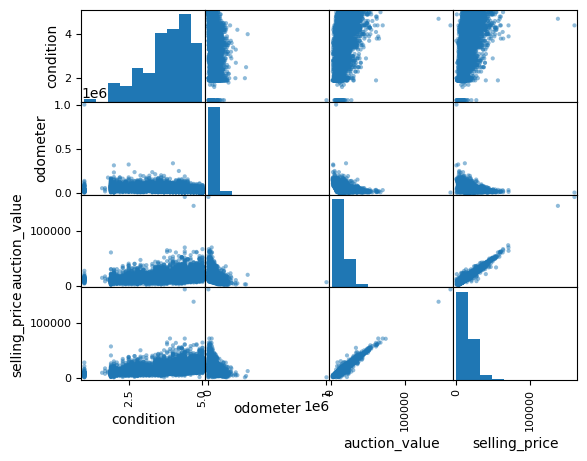

In [46]:
pd.plotting.scatter_matrix(df)

In [51]:
correlation = df[['auction_value','selling_price']].corr()
print(correlation)

               auction_value  selling_price
auction_value       1.000000       0.975612
selling_price       0.975612       1.000000


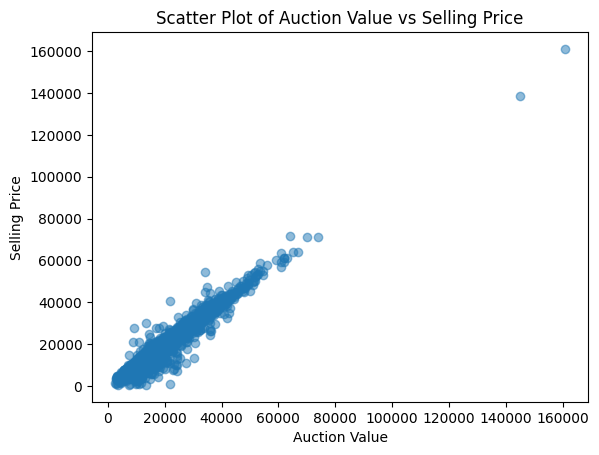

In [54]:
plt.scatter(df['auction_value'], df['selling_price'], alpha=0.5)
plt.xlabel("Auction Value")
plt.ylabel("Selling Price")
plt.title("Scatter Plot of Auction Value vs Selling Price")
plt.show()

Except auction_value I will be keeping all the features

We should keep these features because they all logically influence the selling price of a car. For numerical features, the condition of the car matters; a well-maintained vehicle sells for more. The odometer reading is crucial since lower mileage usually means a higher price.

Auction value is also important because it provides an estimated market price. Since auction_value and selling_price provide nearly identical information, including both does not add any new insights. This redundancy can make the model more complex without improving its predictive ability.Instead of learning what actually drives car prices (brand, mileage, condition), the model just memorizes auction_value and does not generalize well.

For categorical features, the make (brand) affects price as some brands hold their value better than others. Transmission type is relevant, as automatic cars often sell for more than manual ones depending on the market. State is also useful because car prices vary by location due to demand differences.

Even though some of these features have missing values, we can fill them in rather than drop the features altogether.

In [90]:
from sklearn.model_selection import train_test_split
features = ['make','transmission','auction_value', 'state', 'condition', 'odometer']

X = df[features]
y = df['selling_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

print(f'Records in training data: {X_train.shape[0]:,}')
print(f'Records in test data: {X_test.shape[0]:,}')
print('\nFeatures:')
print(*X_train.columns, sep='\n')

Records in training data: 7,244
Records in test data: 1,811

Features:
make
transmission
auction_value
state
condition
odometer


## Question 2:
Split the features into two lists, one for the numerical features and another for the categorical features.

In [91]:
numerical_features = ['odometer','condition','auction_value']
categorical_features = ['make', 'transmission', 'state']
print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Numerical Features: ['odometer', 'condition', 'auction_value']
Categorical Features: ['make', 'transmission', 'state']


## Question 3:
 Using the numerical variables, create a pipeline that replaces the missing values with the median and then standardizes the values using a standard scaler.

In [92]:
numerical_pipeline = Pipeline ([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

print(numerical_pipeline)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])


## Question 4:
Using the categorical variables, create a pipeline that replaces the missing values with the most frequent and then use one-hot encoding to convert the data to numerical arrays.
- You should be dropping one category from each variable when using the one-hot encoder.  
- To ensure the pipeline doesn't break when it receives new/unexpected categories, you should ignore new categories.
- Use a fit transformer on the training dataset to validate all the columns are now numeric and to determine how many columns the transformed data contains.

In [93]:
categorical_features = ['make', 'transmission', 'state']

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

X_train_categorical = categorical_pipeline.fit_transform(X_train[categorical_features])

print("Transformed data is numeric:",X_train_categorical.dtype == 'float64')
print(f"Transformed columns: {X_train_categorical.shape[1]}")


Transformed data is numeric: True
Transformed columns: 41


## Question 5:

Combine the numerical and categorical pipelines into one data processing pipeline.
- Use a fit transformers and the training dataset to verify the data has no missing values and the correct number of columns.

In [94]:
complete_pipeline = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])

X_train_ = complete_pipeline.fit_transform(X_train)

print(f"Final shape of processed training data: {X_train_.shape}")
print(f"Missing values after transformation: {pd.DataFrame(X_train_).isnull().sum().sum()}")


Final shape of processed training data: (7244, 44)
Missing values after transformation: 0


## Question 6:

Add a linear regression model to the pipeline.
- Report what the $R^2$ is using the `test` data.  

In [95]:
pipeline_with_model = Pipeline([
    ('preprocessing', complete_pipeline),
    ('model', LinearRegression())
])

pipeline_with_model.fit(X_train, y_train)

y_pred = pipeline_with_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f'R² score on test data: {r2:.4f}')


R² score on test data: 0.8838


## Question 7:

Create a plot(s) of the residuals. Do you have any concerns about patterns in the residuals that the model is neglecting to pick-up?
- Include a sentence or two on what you observe.

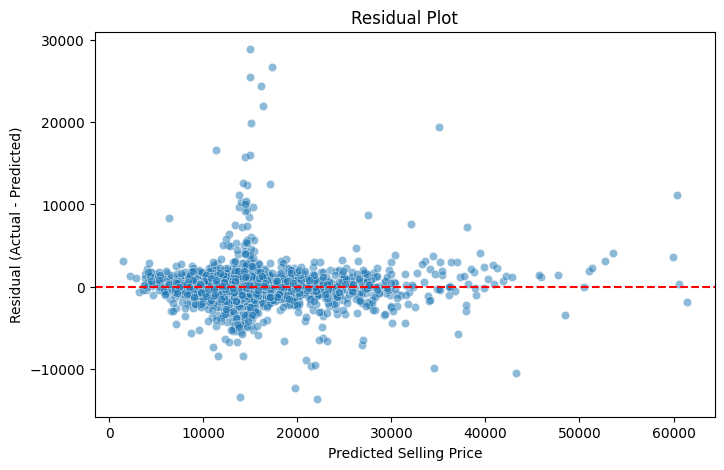

In [98]:
residuals = y_test - y_pred


plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Selling Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

In [ ]:
#This model works better for lower prices but doesn't perform great for expensive cars.

Insert description here.

## Question 8:

Modify the pipeline to use a ridge regression model with an alpha value of 100. How does this change the $R^2$?

In [97]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline


ridge_pipeline = Pipeline([
    ('preprocessing', complete_pipeline),
    ('model', Ridge(alpha=100))
])


ridge_pipeline.fit(X_train, y_train)

r2_ridge = ridge_pipeline.score(X_test, y_test)
print(f'R² Score with Ridge Regression (α=100): {r2_ridge:.4f}')


R² Score with Ridge Regression (α=100): 0.8825
